<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/IntermediateDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Deep Learning

In [ ]:
%%bash
pip install --no-cache-dir -qU \
    torch torchvision torchaudio torchmetrics

## Training robust neural networks

In [3]:
import os
os.makedirs("data", exist_ok=True)

In [2]:
%%bash
cd ./data
unzip -q water_potability.zip

Features shape: torch.Size([128, 9]),
Labels shape: torch.Size([128])


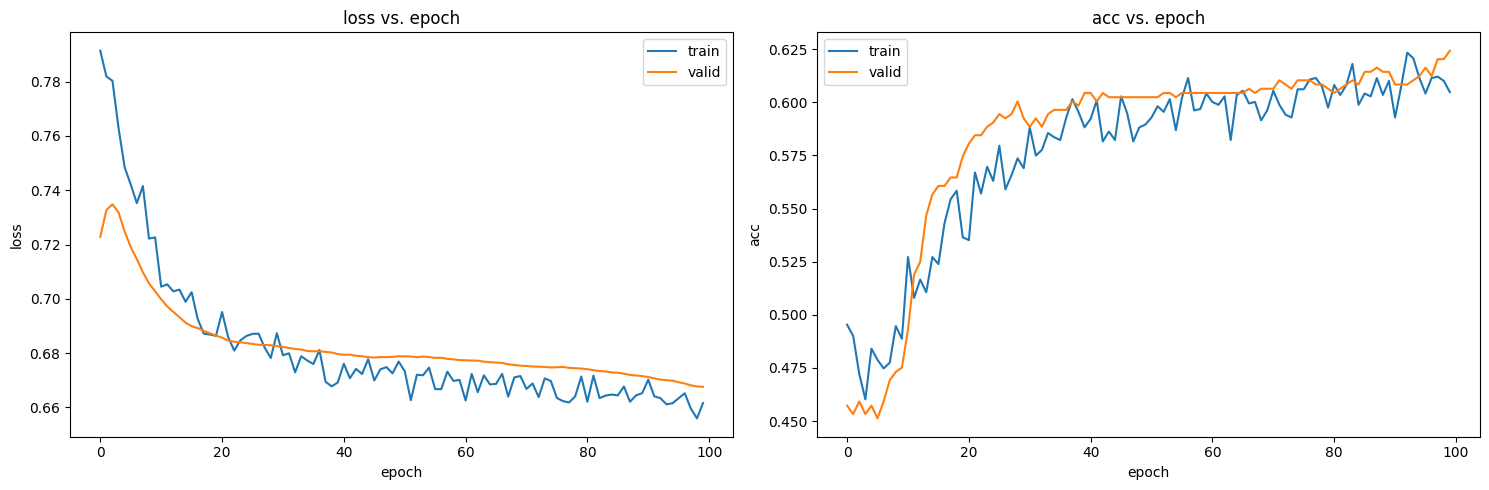

In [4]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import torch
torch.manual_seed(seed=42)
import torchmetrics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

class WaterDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy(dtype=np.float32)

    # Implement __len__ to return the number of data samples
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        features = self.data[idx, :-1]
        # Assign last data column to label
        label = self.data[idx, -1]
        return features, label

# Create an instance of the WaterDataset
dataset_train = WaterDataset("./data/water_potability/water_train.csv")
dataset_test = WaterDataset("./data/water_potability/water_test.csv")

# Create a DataLoader based on dataset_train
dataloader_train = torch.utils.data.DataLoader(
    dataset=dataset_train, batch_size=128, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(
    dataset=dataset_test, batch_size=32, shuffle=False)

# Get a batch of features and labels
features, labels = next(iter(dataloader_train))
if torch.cuda.is_available():
    features = features.cuda()
    labels = labels.cuda()
print(f"Features shape: {features.shape},\nLabels shape: {labels.shape}")

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the three linear layers, apply He initialization
        # Add two batch normalization layers
        self.fc1 = torch.nn.Linear(in_features=9, out_features=16)
        torch.nn.init.kaiming_uniform_(tensor=self.fc1.weight)
        self.bn1 = torch.nn.BatchNorm1d(num_features=16)

        self.fc2 = torch.nn.Linear(in_features=16, out_features=8)
        torch.nn.init.kaiming_uniform_(tensor=self.fc2.weight)
        self.bn2 = torch.nn.BatchNorm1d(num_features=8)

        self.fc3 = torch.nn.Linear(in_features=8, out_features=1)
        torch.nn.init.kaiming_uniform_(tensor=self.fc3.weight,
            nonlinearity="sigmoid")
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x):
        # Pass x through linear layers adding activations
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.nn.functional.elu(x)
        x = self.dropout(x)

        # Pass x through the second set of layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.nn.functional.elu(x)
        x = self.dropout(x)

        x = torch.nn.functional.sigmoid(self.fc3(x))
        return x

net = Net()
criterion = torch.nn.BCELoss()
# Define the Adam optimizer
optimizer = torch.optim.Adam(params=net.parameters(),
    lr=1e-3, weight_decay=1e-4)
# Set up binary accuracy metric
acc = torchmetrics.Accuracy(task="binary")
if torch.cuda.is_available():
    net = net.cuda()
    acc = acc.cuda()

history = {
    "train_loss": [], "train_acc": [],
    "valid_loss": [], "valid_acc": []
}
for epoch in range(100):
    train_loss = 0.0
    for features, labels in dataloader_train:
        if torch.cuda.is_available():
            features = features.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        # Get predicted probabilities
        preds = net(features)
        acc(target=labels.view(-1, 1), preds=(preds>=0.5).float())
        loss = criterion(input=preds, target=labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(dataloader_train)
    history["train_loss"].append(train_loss)
    # Compute total accuracy
    train_acc = acc.compute().item()
    history["train_acc"].append(train_acc)
    acc.reset()

    valid_loss = 0.0
    net.eval()
    with torch.no_grad():
        for features, labels in dataloader_test:
            if torch.cuda.is_available():
                features = features.cuda()
                labels = labels.cuda()
            preds = net(features)
            acc(target=labels.view(-1, 1), preds=(preds>=0.5).float())
            loss = criterion(input=preds, target=labels.view(-1, 1))
            valid_loss += loss.item()
        valid_loss = valid_loss / len(dataloader_test)
        history["valid_loss"].append(valid_loss)
        valid_acc = acc.compute().item()
        history["valid_acc"].append(valid_acc)
        acc.reset()
    net.train()

df_history = pd.DataFrame(history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, m in zip(axes, ["loss", "acc"]):
    sns.lineplot(ax=ax, data=df_history, label="train",
        x=df_history.index, y=f"train_{m}")
    try:
        sns.lineplot(ax=ax, data=df_history, label="valid",
            x=df_history.index, y=f"valid_{m}")
    except Exception:
        pass
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

## Convolutional Neural Networks

In [5]:
import os
os.makedirs("data", exist_ok=True)

In [7]:
%%bash
cd ./data
unzip -q clouds.zip

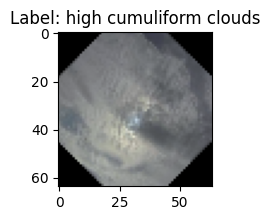

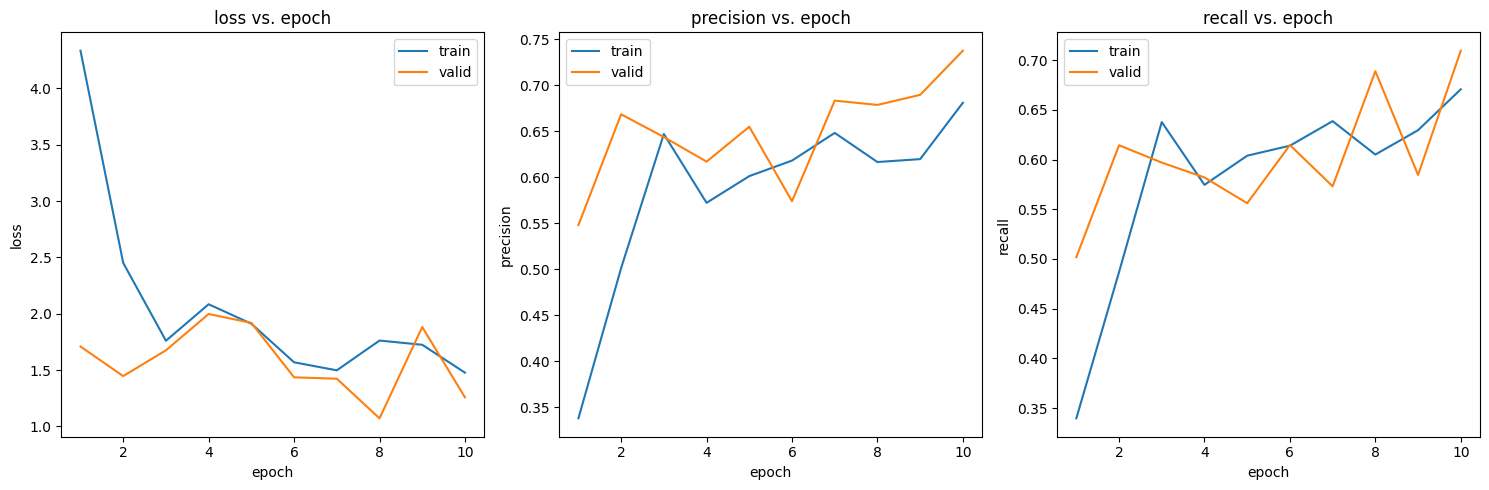

Valid precision per class: {'cirriform clouds': 0.6333333253860474, 'clear sky': 0.9117646813392639, 'cumulonimbus clouds': 0.7692307829856873, 'cumulus clouds': 0.612500011920929, 'high cumuliform clouds': 0.5680000185966492, 'stratiform clouds': 0.8947368264198303, 'stratocumulus clouds': 0.7727272510528564}
Valid recall per class: {'cirriform clouds': 0.4935064911842346, 'clear sky': 0.96875, 'cumulonimbus clouds': 0.9090909361839294, 'cumulus clouds': 0.8166666626930237, 'high cumuliform clouds': 0.6893203854560852, 'stratiform clouds': 0.8500000238418579, 'stratocumulus clouds': 0.23943662643432617}


In [15]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import torch
torch.manual_seed(seed=42)
import torchvision
import torchmetrics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Compose transformations
train_transforms = torchvision.transforms.Compose([
    # Add horizontal flip and rotation
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.RandomAutocontrast(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(64, 64)),
])
# Create Dataset using ImageFolder
dataset_train = torchvision.datasets.ImageFolder(
    root="./data/clouds/clouds_train", transform=train_transforms
)
dataloader_train = torch.utils.data.DataLoader(
  dataset=dataset_train, shuffle=True, batch_size=16
)

test_transforms = torchvision.transforms.Compose([
    # No data augmentation at test time
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(64, 64))
])
dataset_test = torchvision.datasets.ImageFolder(
    root="./data/clouds/clouds_test", transform=test_transforms
)
dataloader_test = torch.utils.data.DataLoader(
    dataset=dataset_test, shuffle=False, batch_size=16
)

image, label = next(iter(dataloader_train))
# Reshape the image tensor
image = image[-1].squeeze().permute(1, 2, 0)
# Display the image
plt.figure(figsize=(2, 2))
plt.imshow(image)
label = [k for k, v in dataset_train.class_to_idx.items()
    if v==label[-1]][0]
plt.title(label=f"Label: {label}")
plt.show()

class Net(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32,
                kernel_size=(3, 3), padding=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2)),

            torch.nn.Conv2d(in_channels=32, out_channels=64,
                kernel_size=(3, 3), padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2)),
            torch.nn.Flatten(),
        )
        torch.nn.init.kaiming_uniform_(tensor=self.feature_extractor[0].weight)
        torch.nn.init.kaiming_uniform_(tensor=self.feature_extractor[4].weight)
        # Define classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(in_features=64*16*16, out_features=num_classes)
        )
        torch.nn.init.kaiming_uniform_(tensor=self.classifier[1].weight)

    def forward(self, x):
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        # x = torch.nn.functional.softmax(x)
        return x

# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
# Define metrics
metric_precision = torchmetrics.Precision(
    task="multiclass", num_classes=7, average=None)
metric_recall = torchmetrics.Recall(
    task="multiclass", num_classes=7, average=None)

if torch.cuda.is_available():
    net = net.cuda()
    metric_precision = metric_precision.cuda()
    metric_recall = metric_recall.cuda()

history = {
    "train_loss": [], "train_precision": [], "train_recall": [],
    "valid_loss": [], "valid_precision": [], "valid_recall": []
}
for epoch in range(10):
    train_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        preds = net(images)
        metric_precision(target=labels,
            preds=preds.argmax(dim=-1))
        metric_recall(target=labels,
            preds=preds.argmax(dim=-1))
        loss = criterion(input=preds, target=labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(dataloader_train)
    history["train_loss"].append(train_loss)
    train_precision = metric_precision.compute()
    history["train_precision"].append(train_precision.mean().item())
    metric_precision.reset()
    train_recall = metric_recall.compute()
    history["train_recall"].append(train_recall.mean().item())
    metric_recall.reset()

    valid_loss = 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in dataloader_test:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            preds = net(images)
            metric_precision(target=labels,
                preds=preds.argmax(dim=-1))
            metric_recall(target=labels,
                preds=preds.argmax(dim=-1))
            loss = criterion(input=preds, target=labels)
            valid_loss += loss.item()
        valid_loss = valid_loss / len(dataloader_test)
        history["valid_loss"].append(valid_loss)
        valid_precision = metric_precision.compute()
        history["valid_precision"].append(valid_precision.mean().item())
        metric_precision.reset()
        valid_recall = metric_recall.compute()
        history["valid_recall"].append(valid_recall.mean().item())
        metric_recall.reset()
    net.train()

df_history = pd.DataFrame(history)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, m in zip(axes, ["loss", "precision", "recall"]):
    sns.lineplot(ax=ax, data=df_history, label="train",
        x=df_history.index+1, y=f"train_{m}")
    try:
        sns.lineplot(ax=ax, data=df_history, label="valid",
            x=df_history.index+1, y=f"valid_{m}")
    except Exception:
        pass
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

# Get precision per class
valid_precision_per_class = {k: valid_precision[v].item()
    for k, v in dataset_test.class_to_idx.items()}
print("Valid precision per class:", valid_precision_per_class)

# Get recall per class
valid_recall_per_class = {k: valid_recall[v].item()
    for k, v in dataset_test.class_to_idx.items()}
print("Valid recall per class:", valid_recall_per_class)

## Recurrent Neural Networks

In [ ]:
import os
os.makedirs("data", exist_ok=True)

In [ ]:
%%bash
cd ./data
unzip

In [ ]:
import numpy as np
np.random.seed(seed=42)
import torch
torch.manual_seed(seed=42)

def create_sequences(df, seq_length):
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
      	# Define inputs
        x = df.iloc[i:(i+seq_length), 1]
        # Define target
        y = df.iloc[i+seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Use create_sequences to create inputs and targets
X_train, y_train = create_sequences(train_data, 24*4)
print(X_train.shape, y_train.shape)

# Create TensorDataset
dataset_train = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
)
print(len(dataset_train))

In [ ]:
import os
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import torch
torch.manual_seed(seed=42)

class ElectricConsumpDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, seq_length):
        super().__init__()
        df = pd.read_csv(csv_path)
        self.data = np.array(df["consumption"],
            dtype=np.float32)
        self.seq_length = seq_length

    def __len__(self):
        return self.data.shape[0] - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:(idx + self.seq_length)]
        y = self.data[idx+self.seq_length]
        return x, y

seq_length = 24*4
input_dir = "./data/electricity_consump"
os.makedirs(input_dir, exist_ok=True)

dataset_train = ElectricConsumpDataset(
    csv_path=os.path.join(input_dir, "electricity_train.csv"),
    seq_length=seq_length
)
dataloader_train = torch.utils.data.DataLoader(
    dataset=dataset_train, batch_size=32, shuffle=True
)

dataset_test = ElectricConsumpDataset(
    csv_path=os.path.join(input_dir, "electricity_test.csv"),
    seq_length=seq_length)
dataset_test = torch.utils.data.DataLoader(
    dataset=dataset_test, batch_size=32, shuffle=False)

features, labels = next(iter(dataloader_train))
print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")

class Net(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define RNN layer
        self.rnn = torch.nn.RNN(
            input_size=input_size, hidden_size=32,
            num_layers=2, batch_first=True
        )
        self.fc = torch.nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        # Initialize first hidden state with zeros
        h0 = torch.zeros(2, x.size(0), 32)
        # Pass x and h0 through recurrent layer
        out, _ = self.rnn(x, h0)
        # Pass recurrent layer's last output through linear layer
        out = self.fc(out[:, -1, :])
        return out

net = Net()
# Set up MSE loss
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(),
    lr=1e-4)

num_epochs = 3
for epoch in range(num_epochs):
    for seqs, labels in dataloader_train:
        if torch.cuda.is_available():
            seqs = seqs.cuda()
            labels = labels.cuda()
        # Reshape model inputs
        seqs = seqs.view(16, 96, 1)
        # Get model outputs
        preds = net(seqs)
        # Compute loss
        loss = criterion(input=preds, target=labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Define MSE metric
mse = torchmetrics.MeanSquaredError()

net.eval()
with torch.no_grad():
    for seqs, labels in dataloader_test:
        seqs = seqs.view(32, 96, 1)
        # Pass seqs to net and squeeze the result
        outputs = net(seqs).squeeze()
        mse(outputs, labels)

# Compute final metric value
test_mse = mse.compute()
print(f"Test MSE: {test_mse}")

Features shape: torch.Size([128, 96]), Labels shape: torch.Size([128])


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define lstm layer
        self.lstm = torch.nn.LSTM(
            input_size=input_size, hidden_size=32,
            num_layers=2, batch_first=True
        )
        self.fc = torch.nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        # Initialize long-term memory
        c0 = torch.zeros(2, x.size(0), 32)
        # Pass all inputs to lstm layer
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
net = Net()
# Set up MSE loss
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(),
    lr=1e-4)

num_epochs = 3
for epoch in range(num_epochs):
    for seqs, labels in dataloader_train:
        # Reshape model inputs
        seqs = seqs.view(16, 96, 1)
        # Get model outputs
        preds = net(seqs)
        # Compute loss
        loss = criterion(input=preds, target=labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Define MSE metric
mse = torchmetrics.MeanSquaredError()

net.eval()
with torch.no_grad():
    for seqs, labels in dataloader_test:
        seqs = seqs.view(32, 96, 1)
        # Pass seqs to net and squeeze the result
        outputs = net(seqs).squeeze()
        mse(outputs, labels)

# Compute final metric value
test_mse = mse.compute()
print(f"Test MSE: {test_mse}")

## Multi-Input & Multi-Output

In [ ]:
import torch
torch.manual_seed(seed=42)
import torchvision
import torchmetrics
import PIL

# Print the sample at index 100
print(samples[100])

class OmniglotDataset(torch.utils.data.Dataset):
    def __init__(self, transform, samples):
		# Assign transform and samples to class attributes
        self.transform = transform
        self.samples = samples

    def __len__(self):
		# Return number of samples
        return len(self.samples)

    def __getitem__(self, idx):
      	# Unpack the sample at index idx
        img_path, alphabet, label = self.samples[idx]
        img = PIL.Image.open(img_path).convert('L')
        # Transform the image
        img = self.transform(img)
        return img, alphabet, label

# Create dataset_train
dataset_train = OmniglotDataset(
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(size=(64, 64)),
    ]),
    samples=samples
)
# Create dataloader_train
dataloader_train = torch.utils.data.DataLoader(
    dataset=dataset_train, shuffle=True, batch_size=32
)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define sub-networks as sequential models
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)
        )
        self.alphabet_layer = nn.Sequential(
            nn.Linear(30, 8),
            nn.ELU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 + 8, 964),
        )

    def forward(self, x_image, x_alphabet):
		# Pass the x_image and x_alphabet through appropriate layers
        x_image = self.image_layer(x_image)
        x_alphabet = self.alphabet_layer(x_alphabet)
        # Concatenate x_image and x_alphabet
        x = torch.cat((x_image, x_alphabet), dim=1)
        return self.classifier(x)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)
        )
        # Define the two classifier layers
        self.classifier_alpha = nn.Linear(128, 30)
        self.classifier_char = nn.Linear(128, 964)

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05)

for epoch in range(1):
    for images, labels_alpha, labels_char in dataloader_train:
        optimizer.zero_grad()
        outputs_alpha, outputs_char = net(images)
        # Compute alphabet classification loss
        loss_alpha = criterion(outputs_alpha, labels_alpha)
        # Compute character classification loss
        loss_char = criterion(outputs_char, labels_char)
        # Compute total loss
        loss = loss_alpha + loss_char
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate_model(model):
    # Define accuracy metrics
    acc_alpha = Accuracy(task="multiclass", num_classes=30)
    acc_char = Accuracy(task="multiclass", num_classes=964)

    model.eval()
    with torch.no_grad():
        for images, labels_alpha, labels_char in dataloader_test:
            # Obtain model outputs
            outputs_alpha, outputs_char = model(images)
            _, pred_alpha = torch.max(outputs_alpha, 1)
            _, pred_char = torch.max(outputs_char, 1)
			# Update both accuracy metrics
            acc_alpha(pred_alpha, labels_alpha)
            acc_char(pred_char, labels_char)

    print(f"Alphabet: {acc_alpha.compute()}")
    print(f"Character: {acc_char.compute()}")